In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# loading data
train_df = pd.read_csv('DATASETS/train.csv', low_memory=False)
store_df = pd.read_csv('DATASETS/store.csv', low_memory=False)

In [17]:
# merging the data and displaying starting types of all column data
df = pd.merge(train_df, store_df, on='Store', how='left')
df.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [18]:
# getting number of rows and columns
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

Rows: 1017209
Columns: 18


In [19]:
df['Date'] = pd.to_datetime(df['Date'])

In [20]:
# label encode all the following columns
cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
for col in cols:
    df[col] = df[col].astype(str)
    df[col] = LabelEncoder().fit_transform(df[col])

In [21]:
# converting string numbers into just numbers
cols = ['Open', 'Promo', 'Promo2', 'SchoolHoliday']
for col in cols:
    df[col] = df[col].astype(int)

In [22]:
df.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int32
Promo                                 int32
StateHoliday                          int32
SchoolHoliday                         int32
StoreType                             int32
Assortment                            int32
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int32
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                         int32
dtype: object

In [23]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,3
1,2,5,2015-07-31,6064,625,1,1,0,1,0,0,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,2,2,620.0,9.0,2009.0,0,NaN,NaN,3
4,5,5,2015-07-31,4822,559,1,1,0,1,0,0,29910.0,4.0,2015.0,0,NaN,NaN,3


# Hypothesis Testing

## Conclusion 1: Stores with ongoing promotions have higher sales.

**Statistical method**: Two-sample t-test

**Null (H0)**: The mean sales for stores with Promo = 0 is equal to the mean sales for stores with Promo = 1.

**Alternative (Ha)**: The mean sales for stores with Promo = 1 is greater than that of stores with Promo = 0.

In [11]:
promo_df = df[df["Promo"] == 1]
nopromo_df = df[df["Promo"] == 0]

pval = ttest_ind(promo_df["Sales"], nopromo_df["Sales"], equal_var=False, alternative='greater').pvalue
print(f"P-value = {pval}")

P-value = 0.0


We have found that the p-value is **effectively 0**. There is very strong evidence that sales are higher with promotions compared to without promotions. We are able to reject the null hypothesis. We are able to see this in the plot below, promotions tend to result in a higher median and overall sales.

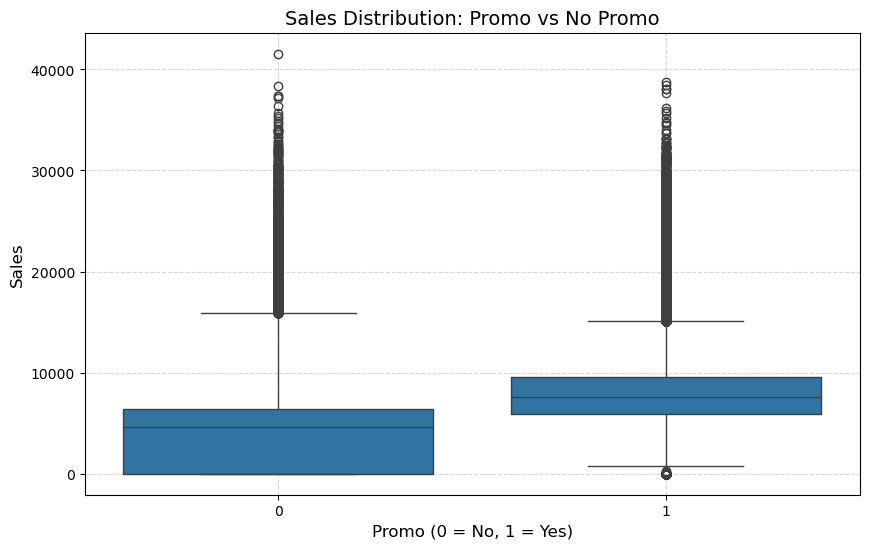

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Promo", y="Sales", data=df)
plt.title("Sales Distribution: Promo vs No Promo", fontsize=14)
plt.xlabel("Promo (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Conclusion 2: Sales amounts are strongly correlated with customer amounts

**Statistical method**: Correlation analysis (Pearson)

In [13]:
corr = df["Sales"].corr(df["Customers"])
print(f"Pearson Correlation Coefficient: {corr}")

Pearson Correlation Coefficient: 0.894710773301698


We have found a correlation coefficient of 0.895, which is very close to 1. This indicates a strong positive linear relationship between the number of customers and total sales. We can interpret this as customers increase, sales tend to increase as well. This is also supported by the accompanying scatterplot.

In [14]:
plt.figure(figsize=(10, 6))
sns.regplot(x="Customers", y="Sales", data=df)
plt.title("Sales vs. Number of Customers", fontsize=16)
plt.xlabel("Number of Customers")
plt.ylabel("Sales")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001DAE7EA0E00> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

## Conclusion 3: Store type has a significant impact on average sales

**Statistical method**: One-Way Anova

**Null Hypothesis (HO)**: There is no significant difference in mean daily sales across different store types.  
**Alternative Hypothesis(Ha)**: At least one store type has a significantly different mean daily sales.

In [ ]:
sales_type = []
for store_type, group in df.groupby('StoreType'):
    sales_type.append(group['Sales'].dropna())

res = f_oneway(*sales_type)
p_value = res.pvalue
print(f"P-value: {p_value}")

P-value: 0.0


We have found that the p-value is **effectively 0**. There is very strong evidence that store type has a significant effect on average sales, meaning that at least one store type differs meaningfully from the others for daily sales performance. 

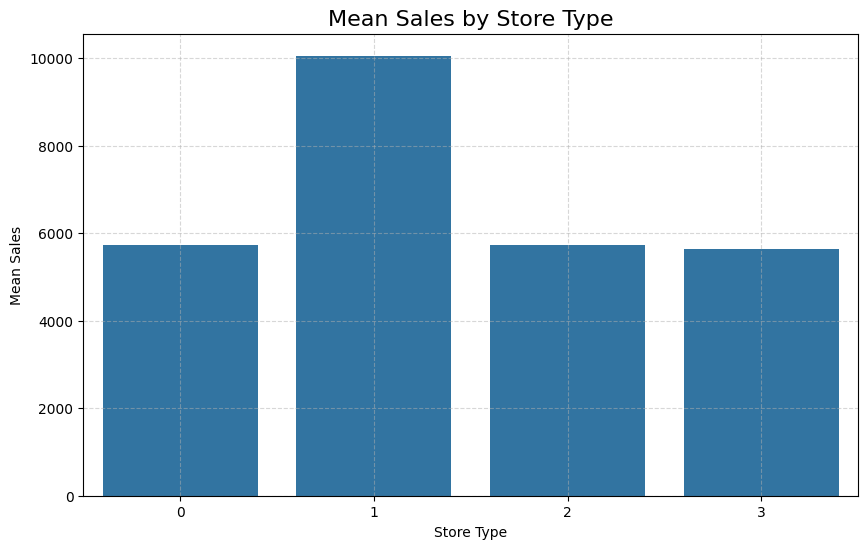

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='StoreType', y='Sales', data=df, errorbar=None)
plt.title("Mean Sales by Store Type", fontsize=16)
plt.xlabel("Store Type")
plt.ylabel("Mean Sales")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Let's run a Post-Hoc Analysis using **Tukey's HSD on Store Type**

In [ ]:
# running turkey's hsd + printing summary
turkey = pairwise_tukeyhsd(endog=df['Sales'], groups=df['StoreType'], alpha=0.05)
print(turkey.summary())

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj   lower      upper    reject
-----------------------------------------------------------
     0      1  4320.6576   0.0  4241.7165  4399.5987   True
     0      2   -14.5505 0.586   -44.1246    15.0237  False
     0      3   -96.3605   0.0  -118.2763   -74.4446   True
     1      2 -4335.2081   0.0 -4417.4191 -4252.9971   True
     1      3 -4417.0181   0.0 -4496.7948 -4337.2414   True
     2      3     -81.81   0.0  -113.5472   -50.0728   True
-----------------------------------------------------------


From before our label encoder mapped a,b,c,d to 0,1,2,3 respectively. So this tells us Store Type b has significantly higher sales than all other types. Store Types a and c are statistically similar in sales performance. Store d, when compared to the rest of the stores, underperforms.

From this point onwards, let us conduct some statistical analysis on the dataset.

Text(0.5, 1.0, 'Sales Distribution')

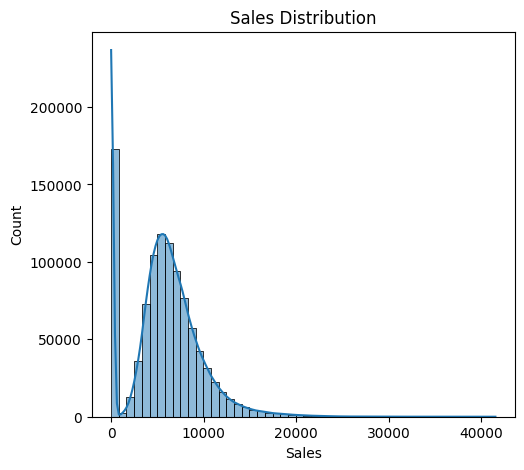

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# make plot with 50 lines and fit curve
sns.histplot(df['Sales'], bins=50, kde=True)
plt.title('Sales Distribution')

From the above graph, we can see that there eare many stores that have very little to no sales, showing that the store is either shut down or has very little business. Moving on, we can see that the stores have an average of ~$5000 in sales. There are some stores that have sales above $10,000 and very little stores that have sales above $20,000


Correlation Matrix:
                         Sales  Customers  CompetitionDistance
Sales                1.000000   0.894711            -0.019229
Customers            0.894711   1.000000            -0.102861
CompetitionDistance -0.019229  -0.102861             1.000000


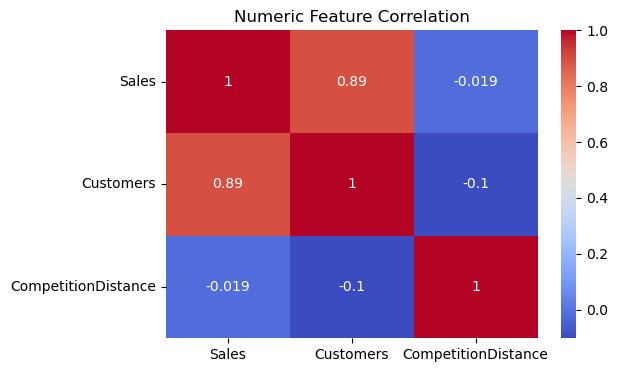

In [24]:
numeric_corr = df[['Sales', 'Customers', 'CompetitionDistance']].corr()
print("\nCorrelation Matrix:\n", numeric_corr)

plt.figure(figsize=(6, 4))
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm')
plt.title('Numeric Feature Correlation')
plt.show()


From the above heatmap, we can see that there is a strong correlation between the number of customers and sales. We an also see that there is very low correlation between Sales and Competition Distance and Customers and Competition Distance. 

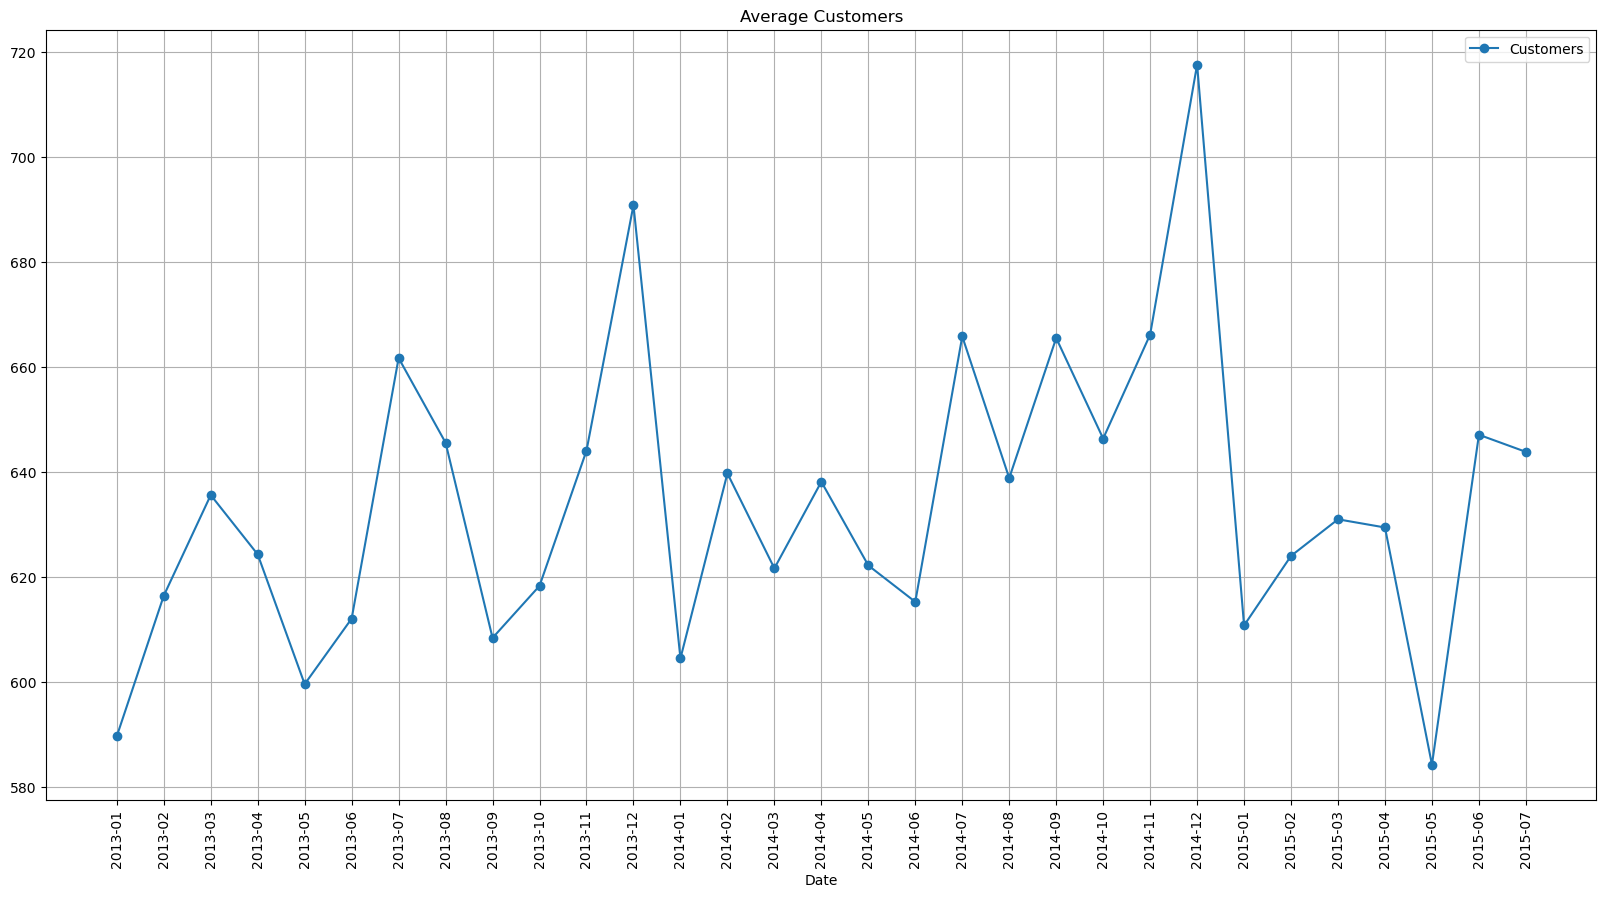

In [31]:
# convert the values to string
df['Date']=df['Date'].apply(lambda x: (str(x)[:7]))
df['Date']=df['Date'].apply(lambda x: (str(x)[:7]))

avr_customers=df.groupby('Date')['Customers'].mean()

plt.figure(figsize=(20, 10))

# Graph to show average customers per month
ax=avr_customers.plot(legend=True, marker='o', title="Average Customers")
ax.set_xticks(range(len(avr_customers)))
xlabels = ax.set_xticklabels(avr_customers.index.tolist(), rotation=90)
ax.grid()

From the above, we can see that there was a spike in sales between November and December 2013 and a sharp becrease betweeen December 2013 and January 2014. Additionally, the same applies with the end and beginning of 2014 and 2015. 